<a href="https://colab.research.google.com/github/ToRaAaAaAaaaaaa/GREEN-DATA-Challenge/blob/main/green_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.cuda.is_available())  # True ならOK
print(torch.cuda.get_device_name(0))  # GPU名を表示

True
Tesla T4


In [ ]:
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 38 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 3s (3,241 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 126666 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

# 必要なモジュールのインストール

In [ ]:
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from datetime import time
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import holidays

In [ ]:
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.5


In [ ]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Installation path: {tf.__file__}")

# モデル関連
Sequential = tf.keras.models.Sequential
Model = tf.keras.models.Model

# レイヤー関連
LSTM = tf.keras.layers.LSTM
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
GRU = tf.keras.layers.GRU

# その他よく使うもの
Adam = tf.keras.optimizers.Adam
EarlyStopping = tf.keras.callbacks.EarlyStopping
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

TensorFlow version: 2.19.0
Installation path: /usr/local/lib/python3.12/dist-packages/tensorflow/__init__.py


# データの定義

In [ ]:
# データの定義
base_dir = '/content/drive/MyDrive/機械学習/signate/SMBC_GREEN_DATA/data/'
train_name = 'train.csv'
test_path = 'test.csv'
train_path = os.path.join(base_dir, train_name)
test_path = os.path.join(base_dir, test_path)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# time列をto_datetime型に
# 文字列処理で+01:00部分を削除してから変換
train['datetime'] = pd.to_datetime(train['time'].astype(str).str.replace(r'\+\d{2}:\d{2}$', '', regex=True))
test['datetime'] = pd.to_datetime(test['time'].astype(str).str.replace(r'\+\d{2}:\d{2}$', '', regex=True))

# カテゴリカル列の欠損値補完、number列への変換

In [ ]:
# train, testのコピー
train_filled = train.copy()
test_filled = test.copy()
# カテゴリカル列の特徴量
categorical_columns_train = train_filled.select_dtypes(include=['object', 'category']).drop(columns=['time'], errors='ignore')
categorical_columns_test = test_filled.select_dtypes(include=['object', 'category']).drop(columns=['time'], errors='ignore')
# missing_categorical_columns_train = categorical_columns_train.columns[categorical_columns_train.isnull().any()].tolist()
# missing_categorical_columns_test = categorical_columns_test.columns[categorical_columns_test.isnull().any()].tolist() 補足:今回は欠損値無!

# columnsの取得
columns_train = categorical_columns_train.columns.tolist()
columns_test = categorical_columns_test.columns.tolist()
# print(columns_train == columns_test) # True
columns_tt = columns_train

# ユニークな値の確認
unique_values_train = categorical_columns_train.nunique()
unique_values_test = categorical_columns_test.nunique()
print(unique_values_train)
# train_filled['valencia_weather_icon'].value_counts()
# print(train_filled['valencia_weather_description'].value_counts())
# print(train_filled['bilbao_weather_main'].value_counts())

# number列への変換(今回は2進エンコーディング)
encoded_train = pd.get_dummies(categorical_columns_train, columns=columns_tt, dtype=int)
encoded_test = pd.get_dummies(categorical_columns_test, columns=columns_tt, dtype=int)
encoded_test = encoded_test.reindex(columns=encoded_train.columns, fill_value=0) #学習データに合わせる
encoded_train_columns = encoded_train.columns.tolist()
encoded_test_columns = encoded_test.columns.tolist()
# 恐らくcity_weather_mainで大体いいのが作れるかと

valencia_weather_main             8
valencia_weather_description     23
valencia_weather_icon            21
madrid_weather_main               9
madrid_weather_description       24
madrid_weather_icon              22
bilbao_weather_main               9
bilbao_weather_description       32
bilbao_weather_icon              24
barcelona_weather_main            9
barcelona_weather_description    29
barcelona_weather_icon           24
seville_weather_main             10
seville_weather_description      29
seville_weather_icon             21
dtype: int64


# number列の欠損値補完

In [ ]:
# スケーリング price_actualは目的変数のため正規化しない
features = train.select_dtypes(include='number').drop(columns=['price_actual']).columns
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_filled[features])
test_scaled = scaler.transform(test_filled[features])

# KNNImputerのインスタンス化
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
train_imputed = imputer.fit_transform(train_scaled)
test_imputed = imputer.transform(test_scaled)

# 必要なら元のスケールに戻す
train_recovered = scaler.inverse_transform(train_imputed)
test_recovered = scaler.inverse_transform(test_imputed)

# DataFrameに再構成
train_filled = pd.DataFrame(train_recovered, columns=features)
test_filled = pd.DataFrame(test_recovered, columns=features)

# 変換したカテゴリカル列を挿入
train_filled[encoded_train_columns] = encoded_train
test_filled[encoded_test_columns] = encoded_test

# price_actual列を元に戻す
price_actual = train['price_actual']
train_filled['price_actual'] = price_actual

# datetime列を戻す
train_filled['datetime'] = train['datetime'].values
test_filled['datetime'] = test['datetime'].values

# 時間的特徴量の追加
train_filled['year'] = train_filled['datetime'].dt.year
train_filled['month'] = train_filled['datetime'].dt.month
train_filled['day_of_week'] = train_filled['datetime'].dt.dayofweek
train_filled['hour'] = train_filled['datetime'].dt.hour

test_filled['year'] = test_filled['datetime'].dt.year
test_filled['month'] = test_filled['datetime'].dt.month
test_filled['day_of_week'] = test_filled['datetime'].dt.dayofweek
test_filled['hour'] = test_filled['datetime'].dt.hour

# 平日、休日データの挿入
es_holidays = holidays.Spain()
train_filled['holidays'] = train_filled['datetime'].apply(lambda x:1 if x in es_holidays else 0)
test_filled['holidays'] = test_filled['datetime'].apply(lambda x:1 if x in es_holidays else 0)

# 気象データの主成分分析

In [ ]:
valencia_weather_data_train = train[["valencia_temp", "valencia_temp_min", "valencia_temp_max", "valencia_pressure", "valencia_humidity", "valencia_wind_speed", "valencia_wind_deg", "valencia_rain_1h", "valencia_rain_3h", "valencia_snow_3h", "valencia_clouds_all", "valencia_weather_id"]]
madrid_weather_data_train = train[["madrid_temp", "madrid_temp_min", "madrid_temp_max", "madrid_pressure", "madrid_humidity", "madrid_wind_speed", "madrid_wind_deg", "madrid_rain_1h", "madrid_rain_3h", "madrid_snow_3h", "madrid_clouds_all", "madrid_weather_id"]]
bilbao_weather_data_train = train[["bilbao_temp", "bilbao_temp_min", "bilbao_temp_max", "bilbao_pressure", "bilbao_humidity", "bilbao_wind_speed", "bilbao_wind_deg", "bilbao_rain_1h", "bilbao_rain_3h", "bilbao_snow_3h", "bilbao_clouds_all", "bilbao_weather_id"]]
barcelona_weather_data_train = train[["barcelona_temp", "barcelona_temp_min", "barcelona_temp_max", "barcelona_pressure", "barcelona_humidity", "barcelona_wind_speed", "barcelona_wind_deg", "barcelona_rain_1h", "barcelona_rain_3h", "barcelona_snow_3h", "barcelona_clouds_all", "barcelona_weather_id"]]
seville_weather_data_train = train[["seville_temp", "seville_temp_min", "seville_temp_max", "seville_pressure", "seville_humidity", "seville_wind_speed", "seville_wind_deg", "seville_rain_1h", "seville_rain_3h", "seville_snow_3h", "seville_clouds_all", "seville_weather_id"]]

valencia_weather_data_test = test[["valencia_temp", "valencia_temp_min", "valencia_temp_max", "valencia_pressure", "valencia_humidity", "valencia_wind_speed", "valencia_wind_deg", "valencia_rain_1h", "valencia_rain_3h", "valencia_snow_3h", "valencia_clouds_all", "valencia_weather_id"]]
madrid_weather_data_test = test[["madrid_temp", "madrid_temp_min", "madrid_temp_max", "madrid_pressure", "madrid_humidity", "madrid_wind_speed", "madrid_wind_deg", "madrid_rain_1h", "madrid_rain_3h", "madrid_snow_3h", "madrid_clouds_all", "madrid_weather_id"]]
bilbao_weather_data_test = test[["bilbao_temp", "bilbao_temp_min", "bilbao_temp_max", "bilbao_pressure", "bilbao_humidity", "bilbao_wind_speed", "bilbao_wind_deg", "bilbao_rain_1h", "bilbao_rain_3h", "bilbao_snow_3h", "bilbao_clouds_all", "bilbao_weather_id"]]
barcelona_weather_data_test = test[["barcelona_temp", "barcelona_temp_min", "barcelona_temp_max", "barcelona_pressure", "barcelona_humidity", "barcelona_wind_speed", "barcelona_wind_deg", "barcelona_rain_1h", "barcelona_rain_3h", "barcelona_snow_3h", "barcelona_clouds_all", "barcelona_weather_id"]]
seville_weather_data_test = test[["seville_temp", "seville_temp_min", "seville_temp_max", "seville_pressure", "seville_humidity", "seville_wind_speed", "seville_wind_deg", "seville_rain_1h", "seville_rain_3h", "seville_snow_3h", "seville_clouds_all", "seville_weather_id"]]

# 全都市の天気データを横に結合
weather_train_all = pd.concat([
    valencia_weather_data_train,
    madrid_weather_data_train,
    bilbao_weather_data_train,
    barcelona_weather_data_train,
    seville_weather_data_train
], axis=1)

weather_test_all = pd.concat([
    valencia_weather_data_test,
    madrid_weather_data_test,
    bilbao_weather_data_test,
    barcelona_weather_data_test,
    seville_weather_data_test
], axis=1)

# スケーリング
scaler = StandardScaler()
weather_train_scaled = scaler.fit_transform(weather_train_all)
weather_test_scaled = scaler.fit_transform(weather_test_all)

# PCA
pca = PCA(n_components=2)  # 必要な次元数を指定
weather_train_pca = pca.fit_transform(weather_train_scaled)
weather_test_pca = pca.fit_transform(weather_test_scaled)

# 主成分の列名を作成
pca_columns = [f'PC{i+1}' for i in range(weather_train_pca.shape[1])]
pca_columns = [f'PC{i+1}' for i in range(weather_test_pca.shape[1])]

# DataFrame として格納
weather_train_pca_df = pd.DataFrame(weather_train_pca, columns=pca_columns)
weather_test_pca_df = pd.DataFrame(weather_test_pca, columns=pca_columns)

# こうすれば test に同じ名前の列ができます
train_filled[pca_columns] = weather_train_pca_df
test_filled[pca_columns] = weather_test_pca_df

In [ ]:
# trainの列名を抽出
all_columns = train_filled.columns.tolist()
all_columns = test_filled.columns.tolist()
# print(len(all_columns)) 出力結果93
num_columns = train_filled.select_dtypes(include='number').columns.tolist()
# len(num_columns) 出力結果76
categorical_columns = train_filled.select_dtypes(include=['object', 'category']).columns.tolist()
# len(categorical_columns) 出力結果16
# あと1つはdatetime

len(all_columns)

377

# 確認_グラフで可視化

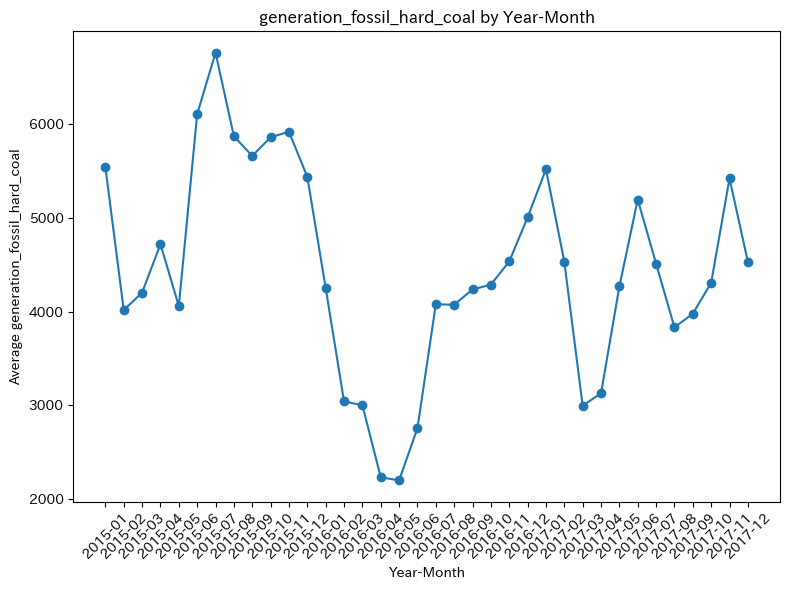

In [ ]:
# # 1. 年月の文字列でグループ化したい場合
train_filled['year_month'] = train_filled['datetime'].dt.to_period('M')
# features = 'price_actual'
features = 'generation_fossil_hard_coal'
# features = 'total_load_actual'
price_data_year_month = train_filled.groupby('year_month')[f'{features}'].mean()

# グラフ
plt.figure(figsize=(8, 6))
plt.plot(price_data_year_month.index.astype(str), price_data_year_month.values, marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel(f'Average {features}')
plt.title(f'{features} by Year-Month')
plt.xticks(rotation=45)  # x軸のラベルを傾けて見やすく
plt.tight_layout()
plt.show()

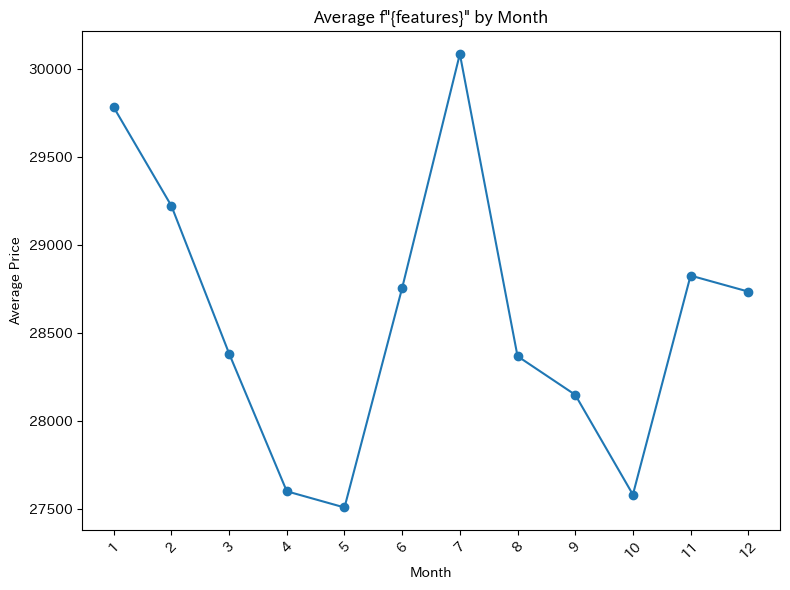

In [ ]:
# 年と月を別々の列として作成
# features = 'price_actual'
# features = 'generation_fossil_hard_coal'
features = 'total_load_actual'
price_data_month = train_filled.groupby(['year', 'month'])[f'{features}'].mean()
price_data_by_month = train_filled.groupby('month')[f'{features}'].mean()

# グラフ
plt.figure(figsize=(8, 6))
plt.plot(price_data_by_month.index.astype(str), price_data_by_month, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average f"{features}" by Month')
plt.xticks(rotation=45)  # x軸のラベルを傾けて見やすく
plt.tight_layout()
plt.show()

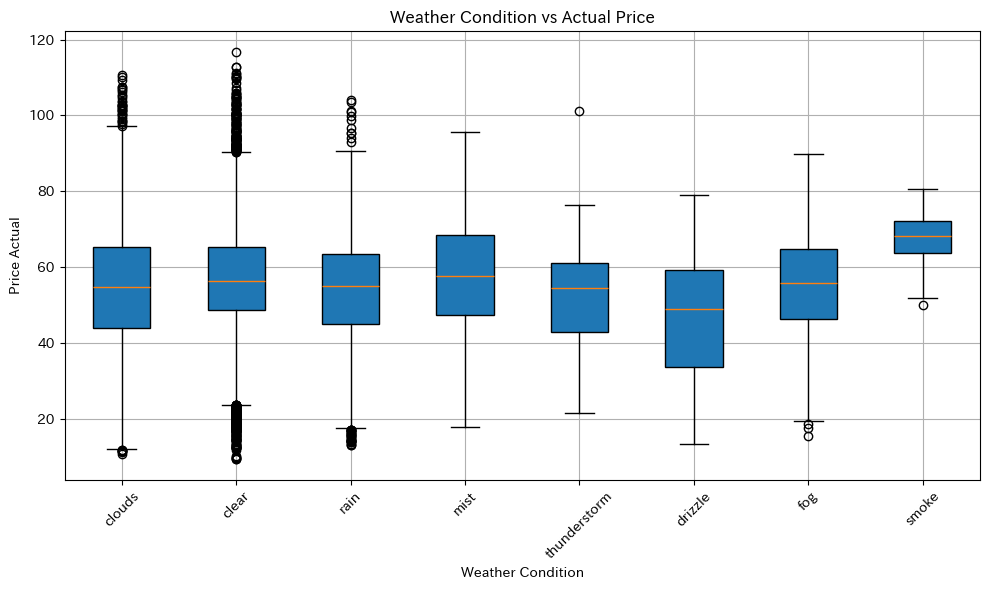

In [ ]:
# 天気条件（one-hot列名の接尾語）
weather_params = ['clouds', 'clear', 'rain', 'mist', 'thunderstorm', 'drizzle', 'fog', 'smoke']

plt.figure(figsize=(10, 6))

# 各天気条件ごとの価格を格納するリスト
# valencia, madrid, bilbao, barcelona, seville
city = 'seville' #ここに入れたい街を入れる
price_by_weather = []

for icon in weather_params:
    col_name = f'{city}_weather_main_{icon}'
    if col_name in train_filled.columns:
        prices = train_filled.loc[train_filled[col_name] == 1, 'price_actual']
        price_by_weather.append(prices)
    else:
        print(f"列 {col_name} は存在しません")

# 箱ひげ図をプロット
plt.boxplot(price_by_weather, patch_artist=True)
plt.xticks(ticks=range(1, len(weather_params)+1), labels=weather_params, rotation=45)
plt.title("Weather Condition vs Actual Price")
plt.ylabel("Price Actual")
plt.xlabel("Weather Condition")
plt.grid(True)
plt.tight_layout()
plt.show()


# 機械学習モデル(めちゃくちゃAI頼み)

In [ ]:
# 時系列クロスバリデーション関数
def time_series_cv(model, X, y, n_splits=5):
    """時系列データ用のクロスバリデーション"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        if hasattr(model, 'fit'):
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
        else:
            # Prophet や ARIMA の場合の処理
            y_pred = custom_predict(model, X_train_fold, y_train_fold, X_val_fold)

        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        scores.append(rmse)

    return np.mean(scores), np.std(scores)

# データ前処理関数
def prepare_lstm_data(X, y, sequence_length=24):
    """LSTMのための系列データ作成"""
    X_sequences, y_sequences = [], []

    for i in range(sequence_length, len(X)):
        X_sequences.append(X[i-sequence_length:i])
        y_sequences.append(y[i])

    return np.array(X_sequences), np.array(y_sequences)

# 1. LightGBMモデル（改良版）
def create_lgb_model():
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'learning_rate': 0.03,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_data_in_leaf': 10,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'verbose': -1
    }
    return params

# 2. XGBoostモデル
def create_xgb_model():
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'reg_alpha': 0.1,      # L1正則化
        'reg_lambda': 0.1,     # L2正則化
        'random_state': 42
    }
    return xgb.XGBRegressor(**params)

# 3. Random Forestモデル
def create_rf_model():
    params = {
        'n_estimators': 200,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }
    return RandomForestRegressor(**params)

# 4. LSTMモデル
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(16, return_sequences=False),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# 5. GRUモデル（LSTMの軽量版）
def create_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# 6. Prophet用のデータ準備
def prepare_prophet_data(df, target_col, date_col=None):
    """Prophet用のデータフォーマット変換"""
    if date_col is None:
        # インデックスが日付の場合
        prophet_df = pd.DataFrame({
            'ds': df.index,
            'y': df[target_col]
        })
    else:
        prophet_df = pd.DataFrame({
            'ds': df[date_col],
            'y': df[target_col]
        })
    return prophet_df

def create_prophet_model():
    """Prophet モデル作成"""
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0
    )
    return model

# 7. SARIMA モデル
def create_sarima_model():
    """SARIMA モデル作成（24時間周期を考慮）"""
    # 電力データの場合、24時間周期が一般的
    model_params = {
        'order': (2, 1, 2),           # (p, d, q)
        'seasonal_order': (1, 1, 1, 24),  # (P, D, Q, s) 24時間周期
        'enforce_stationarity': False,
        'enforce_invertibility': False
    }
    return model_params

# 8. 線形回帰モデル（ベースライン）
def create_ridge_model():
    return Ridge(alpha=1.0, random_state=42)

def create_lasso_model():
    return Lasso(alpha=0.1, random_state=42)

# モデル学習・評価の統合関数
def train_and_evaluate_models(X, y, test_size=0.2):
    """全モデルの学習と評価"""

    # 時系列分割（テストデータは最後の20%）
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # スケーリング
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    results = {}

    # 1. LightGBM
    print("Training LightGBM...")
    lgb_params = create_lgb_model()
    train_data = lgb.Dataset(X_train, y_train)
    val_data = lgb.Dataset(X_test, y_test, reference=train_data)

    lgb_model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=300,
        callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
    )

    lgb_pred = lgb_model.predict(X_test)
    results['LightGBM'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, lgb_pred)),
        'MAE': mean_absolute_error(y_test, lgb_pred),
        'R2': r2_score(y_test, lgb_pred)
    }

    # 2. XGBoost
    print("Training XGBoost...")
    xgb_model = create_xgb_model()

    # 新しい書き方
    xgb_model.fit(
        X_train, y_train,
        # eval_set=[(X_test, y_test)],
        # callbacks=[EarlyStopping(stopping_rounds=20, save_best=True)],
        # verbose=False
        # EarlyStoppingはなぜか動かないためカット
    )

    xgb_pred = xgb_model.predict(X_test)
    results['XGBoost'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, xgb_pred)),
        'MAE': mean_absolute_error(y_test, xgb_pred),
        'R2': r2_score(y_test, xgb_pred)
    }
    # 3. Random Forest
    print("Training Random Forest...")
    rf_model = create_rf_model()
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    results['Random Forest'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, rf_pred)),
        'MAE': mean_absolute_error(y_test, rf_pred),
        'R2': r2_score(y_test, rf_pred)
    }

    # 4. LSTM（時系列データの準備が必要）
    print("Training LSTM...")
    sequence_length = 24  # 24時間分のデータを使用
    if len(X_train) > sequence_length:
        X_train_seq, y_train_seq = prepare_lstm_data(
            X_train_scaled, y_train_scaled, sequence_length
        )
        X_test_seq, y_test_seq = prepare_lstm_data(
            X_test_scaled, scaler_y.transform(y_test.values.reshape(-1, 1)).flatten(),
            sequence_length
        )

        lstm_model = create_lstm_model((sequence_length, X_train.shape[1]))

        early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)

        lstm_model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_test_seq, y_test_seq),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        lstm_pred_scaled = lstm_model.predict(X_test_seq)
        lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled).flatten()
        y_test_lstm = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

        results['LSTM'] = {
            'RMSE': np.sqrt(mean_squared_error(y_test_lstm, lstm_pred)),
            'MAE': mean_absolute_error(y_test_lstm, lstm_pred),
            'R2': r2_score(y_test_lstm, lstm_pred)
        }

    # 5. Ridge回帰
    print("Training Ridge Regression...")
    ridge_model = create_ridge_model()
    ridge_model.fit(X_train_scaled, y_train)
    ridge_pred = ridge_model.predict(X_test_scaled)
    results['Ridge'] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, ridge_pred)),
        'MAE': mean_absolute_error(y_test, ridge_pred),
        'R2': r2_score(y_test, ridge_pred)
    }

    return results

# 使用例
"""
# データの準備
X = train_filled[['generation_fossil_hard_coal', 'total_load_actual', ...]]
y = train_filled['price_actual']

# モデル比較実行
results = train_and_evaluate_models(X, y)

# 結果表示
results_df = pd.DataFrame(results).T
print(results_df.round(4))

# 最良モデルの選択
best_model = results_df['RMSE'].idxmin()
print(f"Best model: {best_model}")
"""

# ハイパーパラメータチューニング用の関数
def optimize_hyperparameters():
    """
    各モデルのハイパーパラメータ最適化の例
    実際の使用時はOptunaやGridSearchCVを使用することを推奨
    """

    # LightGBM用
    lgb_param_grid = {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'feature_fraction': [0.7, 0.8, 0.9],
        'bagging_fraction': [0.7, 0.8, 0.9],
        'min_data_in_leaf': [5, 10, 20]
    }

    # XGBoost用
    xgb_param_grid = {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'subsample': [0.7, 0.8, 0.9]
    }

    # Random Forest用
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    return lgb_param_grid, xgb_param_grid, rf_param_grid

# 特徴量の重要度を測る

In [ ]:
X_pra = train_filled.drop(columns=['price_actual', 'datetime', 'year_month'])
y = train_filled['price_actual']

# 時系列を考慮した分割
split_index = int(len(X_pra) * 0.8)
X_train, X_test = X_pra[:split_index], X_pra[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# パラメータ設定
params = {
    'objective': 'regression',  # または 'binary' for 分類
    'metric': 'rmse',  # または 'binary_logloss' for 分類
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# モデル学習
model = lgb.train(params,
                  train_data,
                  valid_sets=[valid_data],
                  num_boost_round=100,
                  callbacks=[lgb.early_stopping(10)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 5.88296


# 特徴量重要度

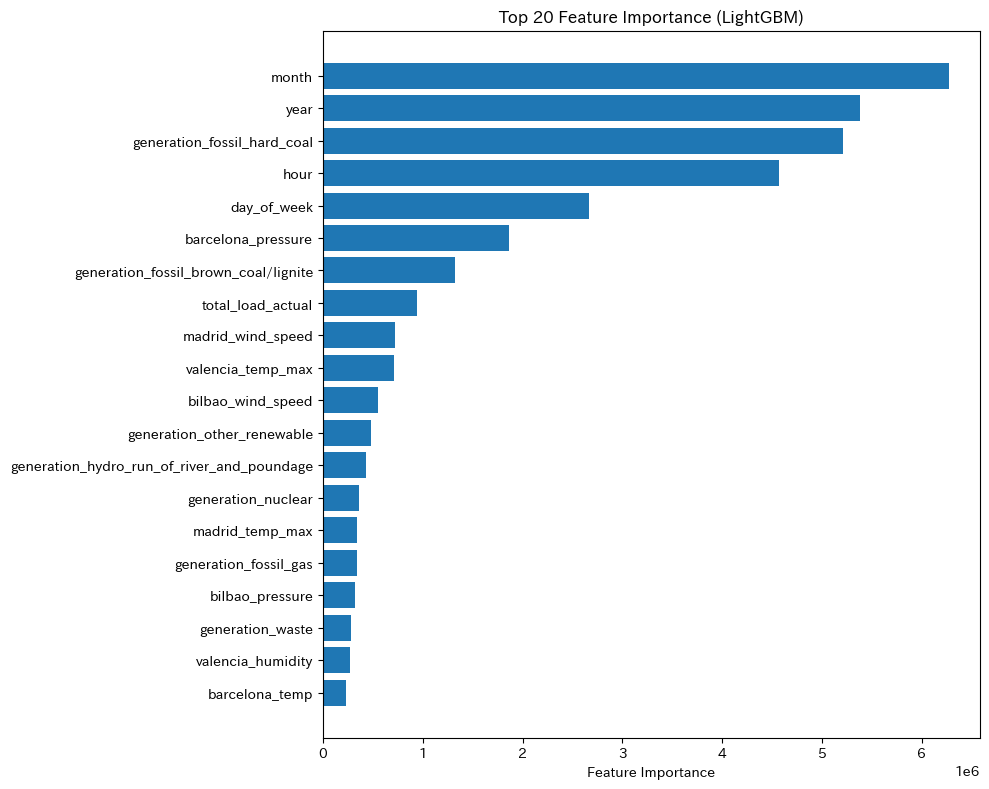

                                         feature    importance
370                                        month  6.271184e+06
369                                         year  5.384348e+06
3                    generation_fossil_hard_coal  5.214903e+06
372                                         hour  4.567807e+06
371                                  day_of_week  2.663805e+06
54                            barcelona_pressure  1.867369e+06
1           generation_fossil_brown_coal/lignite  1.327123e+06
14                             total_load_actual  9.469815e+05
32                             madrid_wind_speed  7.218352e+05
17                             valencia_temp_max  7.080984e+05
44                             bilbao_wind_speed  5.471916e+05
10                    generation_other_renewable  4.852231e+05
6     generation_hydro_run_of_river_and_poundage  4.359591e+05
8                             generation_nuclear  3.634245e+05
29                               madrid_temp_max  3.405

In [ ]:
# 特徴量重要度の取得と可視化
importance = model.feature_importance(importance_type='gain')
feature_names = X_pra.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

# 上位20個の特徴量を可視化
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df.head(20)['feature'],
         feature_importance_df.head(20)['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance_df.head(50))

# 教師あり学習

In [ ]:
X = train_filled[['PC1', 'PC2', 'holidays', 'generation_fossil_hard_coal', 'total_load_actual', 'barcelona_pressure', 'generation_nuclear', 'generation_fossil_brown_coal/lignite', 'generation_other_renewable', 'generation_hydro_run_of_river_and_poundage', 'generation_solar', 'generation_fossil_gas', 'madrid_wind_speed', 'generation_waste', 'valencia_temp_max', 'madrid_pressure', 'barcelona_temp', 'generation_other', 'generation_biomass', 'barcelona_temp_max', 'generation_hydro_pumped_storage_consumption', 'bilbao_pressure', 'bilbao_wind_speed', 'generation_fossil_oil', 'generation_wind_onshore', 'seville_pressure', 'madrid_temp_max', 'valencia_temp_min', 'bilbao_temp_min', 'generation_hydro_water_reservoir', 'month', 'year', 'hour', 'day_of_week']]
y = train_filled['price_actual']

# 全モデル比較実行
results = train_and_evaluate_models(X, y)
print(pd.DataFrame(results).T)

Training LightGBM...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 5.67451
Training XGBoost...
Training Random Forest...
Training LSTM...
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training Ridge Regression...
                   RMSE       MAE        R2
LightGBM       5.674506  4.030255  0.682260
XGBoost        5.738567  4.031577  0.675045
Random Forest  7.399715  5.580251  0.459686
LSTM           6.813473  4.975262  0.543047
Ridge          8.840732  7.126324  0.228755


In [ ]:
# 時系列を考慮した分割
split_index = int(len(X) * 0.7)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

param_grid = {
    'n_estimators': [4000],
    'max_depth': [5], # 大きすぎ×
    'learning_rate': [0.001],
    'reg_lambda': [1.0],
    'min_child_weight': [1],
    'gamma': [0.3],
    'subsample': [0.8],
    'colsample_bytree': [0.9], # 小さすぎ×
    'quantile_alpha': [0.5]
}

base_params = {
    # 'subsample': 1.0,
    'colsample_bytree': 1.0,
    # 'reg_alpha': 1.0,
    # 'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

model = XGBRegressor(**base_params)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1.0,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.9], 'gamma': [0.3],
                         'learning_rate': [0.001], 'max_depth': [5],
                         'min_child_weight': [1], 'n_estimators': [4000],
                         'quantile_alpha': [0.5], 'reg_lambda': [1.0],
                         'subsample': [0.8]},
             scoring='neg_mean_squared_error')

# 教師なし学習

In [ ]:
# 最適なパラメータを確認
print("Best parameters:", grid_search
      .best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'colsample_bytree': 0.9, 'gamma': 0.3, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 4000, 'quantile_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best score: -314.67017101769306


In [ ]:
print("Training final XGBoost model...")
best_model = grid_search.best_estimator_

X_pred = test_filled[['PC1', 'PC2', 'holidays', 'generation_fossil_hard_coal', 'total_load_actual', 'barcelona_pressure', 'generation_nuclear', 'generation_fossil_brown_coal/lignite', 'generation_other_renewable', 'generation_hydro_run_of_river_and_poundage', 'generation_solar', 'generation_fossil_gas', 'madrid_wind_speed', 'generation_waste', 'valencia_temp_max', 'madrid_pressure', 'barcelona_temp', 'generation_other', 'generation_biomass', 'barcelona_temp_max', 'generation_hydro_pumped_storage_consumption', 'bilbao_pressure', 'bilbao_wind_speed', 'generation_fossil_oil', 'generation_wind_onshore', 'seville_pressure', 'madrid_temp_max', 'valencia_temp_min', 'bilbao_temp_min', 'generation_hydro_water_reservoir', 'month', 'year', 'hour', 'day_of_week']]
pred_price_actual = best_model.predict(X_pred)
print('finish')

Training final XGBoost model...
finish


In [ ]:
pred_data = pd.DataFrame({
    'datetime': test['time'],
    'price_actual': pred_price_actual
})
pred_data.to_csv('predictions.csv', index=False, header=False)

# 予測結果の可視化

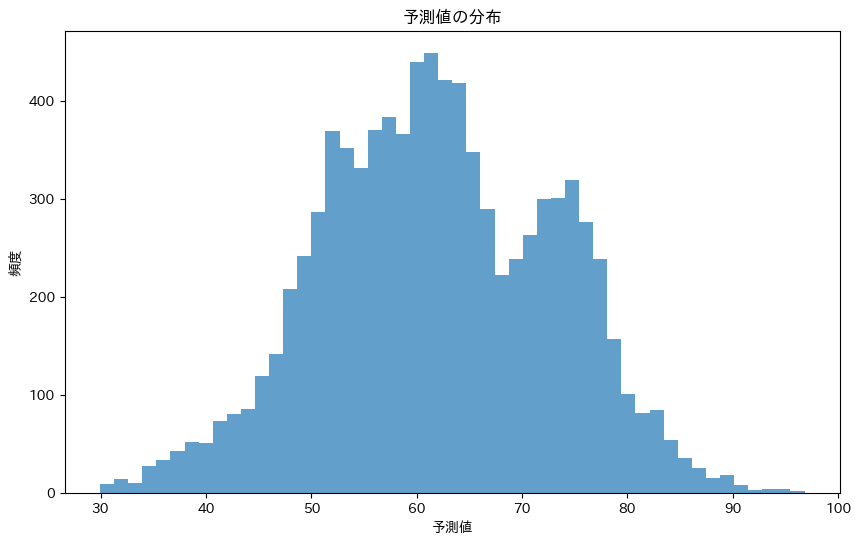

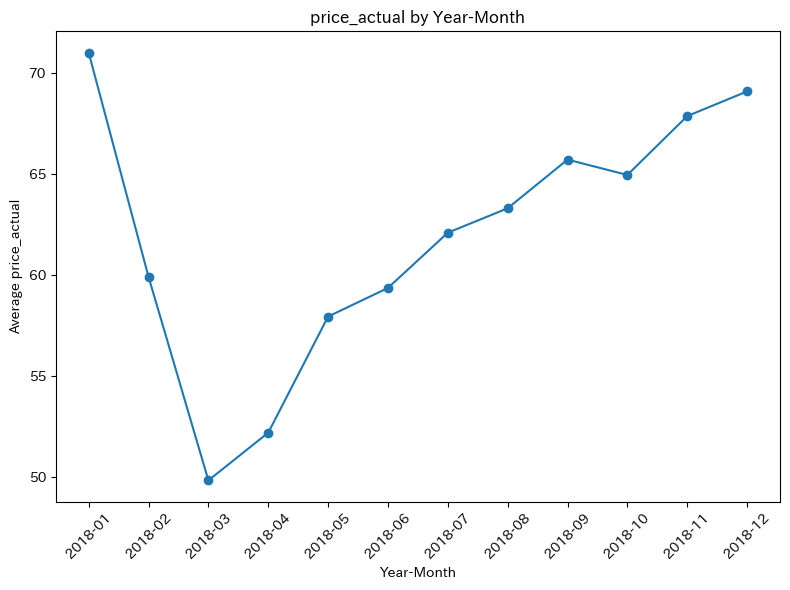

In [ ]:
# 予測値の分布確認
plt.figure(figsize=(10, 6))
plt.hist(pred_price_actual, bins=50, alpha=0.7)
plt.title('予測値の分布')
plt.xlabel('予測値')
plt.ylabel('頻度')
plt.show()

# データ分布
test_filled['price_actual'] = pred_price_actual
test_filled['year_month'] = test_filled['datetime'].dt.to_period('M')
features = 'price_actual'
# features = 'generation_fossil_hard_coal'
# features = 'total_load_actual'
price_data_year_month = test_filled.groupby('year_month')[f'{features}'].mean()

# グラフ
plt.figure(figsize=(8, 6))
plt.plot(price_data_year_month.index.astype(str), price_data_year_month.values, marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel(f'Average {features}')
plt.title(f'{features} by Year-Month')
plt.xticks(rotation=45)  # x軸のラベルを傾けて見やすく
plt.tight_layout()
plt.show()